In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import f_oneway
from shapely import ops
from shapely.ops import nearest_points, unary_union
from shapely.geometry import Point, MultiLineString, MultiPolygon
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import datetime
import os
print(os.getcwd())

/home/philip/DA/eq


In [2]:
# Load the data
quakes = pd.read_csv('data/earthquakes1965_2025.csv')
quakes.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,year,month
0,1965-01-01 07:41:32.610000+00:00,34.144833,-117.488500,2.100,3.89,ml,11.0,123.0,0.1777,0.46,...,earthquake,1.19,2.09,0.063,10.0,reviewed,ci,ci,1965,1
1,1965-01-01 08:04:17.780000+00:00,34.129333,-117.509000,3.310,4.46,ml,13.0,114.0,0.1751,0.41,...,earthquake,0.89,1.59,0.098,8.0,reviewed,ci,ci,1965,1
2,1965-01-01 14:57:45.520000+00:00,19.814333,-155.387500,24.017,4.11,ml,16.0,148.0,NaN,0.10,...,earthquake,0.88,3.25,0.060,4.0,reviewed,hv,hv,1965,1
3,1965-01-01 21:38:31.320000+00:00,35.697000,4.385000,12.400,5.28,mw,NaN,NaN,NaN,NaN,...,earthquake,NaN,25.00,0.300,NaN,reviewed,iscgem,iscgem,1965,1
4,1965-01-01 23:05:00.840000+00:00,19.793667,-155.401333,5.557,3.28,ml,12.0,152.0,NaN,0.18,...,earthquake,0.73,2.28,0.080,2.0,reviewed,hv,hv,1965,1


In [3]:
quakes['date'] = pd.to_datetime(quakes['time'], format='ISO8601')

In [4]:
quakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998880 entries, 0 to 998879
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   time             998880 non-null  object             
 1   latitude         998880 non-null  float64            
 2   longitude        998880 non-null  float64            
 3   depth            998846 non-null  float64            
 4   mag              998880 non-null  float64            
 5   magType          998796 non-null  object             
 6   nst              516052 non-null  float64            
 7   gap              631998 non-null  float64            
 8   dmin             340998 non-null  float64            
 9   rms              835756 non-null  float64            
 10  net              998880 non-null  object             
 11  id               998880 non-null  object             
 12  updated          998880 non-null  object             
 13 

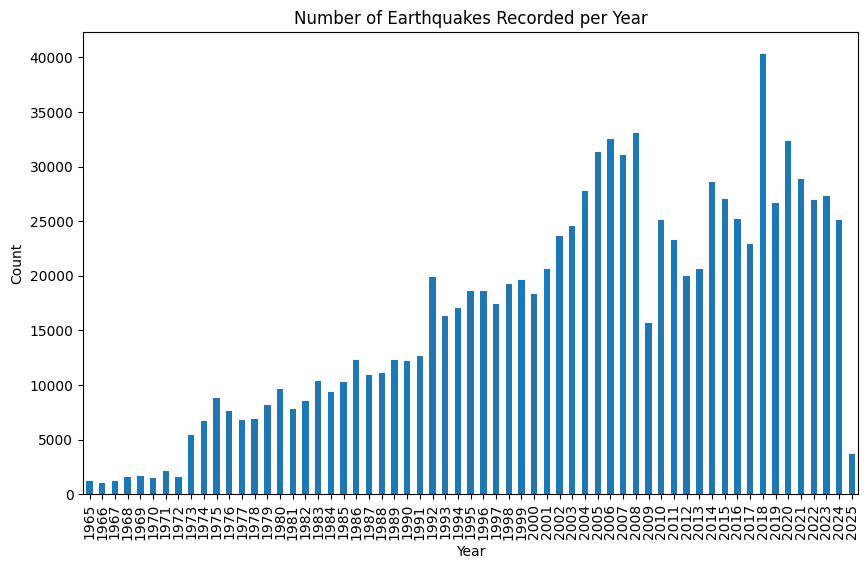

In [5]:
# Group by year and count the number of quakes per year
quakes_per_year = quakes.groupby('year').size()

# Plot the data
plt.figure(figsize=(10, 6))
quakes_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Earthquakes Recorded per Year')
plt.show()

I suspect that this is an artifcact in the data that shows how technology and detection of earthquakes has improved over the past sixty years.  

I have a suspicion that seismograph technology has improved since 1965.  This contention would explain why smaller earthquakes appear to have increased over time.  This problem does not seem to affect magnitude 5 and greater earthquakes. I also wonder if the number of seismographs matters.  The international Registry of Seismograph Stations does seem to keep records of such things.  https://www.isc.ac.uk/registries/  However, the data that they make available does not include when a station came online or went offline.  They only list them as current of closed.

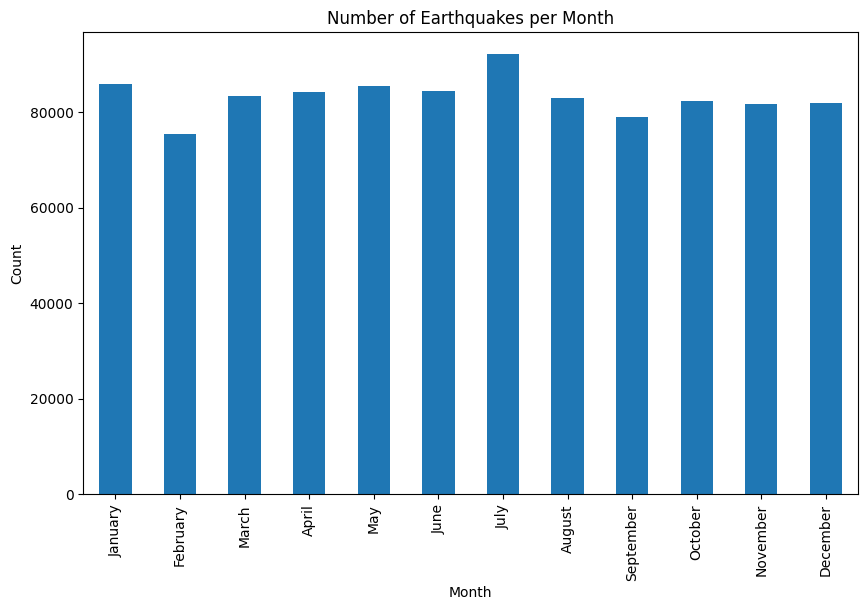

In [13]:
# Group by month and count the number of quakes per month
quakes_per_month = quakes.groupby('month').size()

# Convert month numbers to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
quakes_per_month.index = [month_names[month-1] for month in quakes_per_month.index]

# Plot the data
plt.figure(figsize=(10, 6))
quakes_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Earthquakes per Month')
plt.show()

Is there a difference by month?  February looks a bit low and July looks a bit high.  Is this a statistically significant different?  Let's find out.

ANOVA

null hypothesis:  the counts of the months are the same

alternative hypothesis:  the counts of the months are different

In [41]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Prepare the data for ANOVA
data = [quakes[quakes['month'] == month].shape[0] for month in range(1, 13)]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*data)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the counts of earthquakes for different months.")
else:
    print("There is no statistically significant difference between the counts of earthquakes for different months.")


F-statistic: nan
P-value: nan
There is no statistically significant difference between the counts of earthquakes for different months.


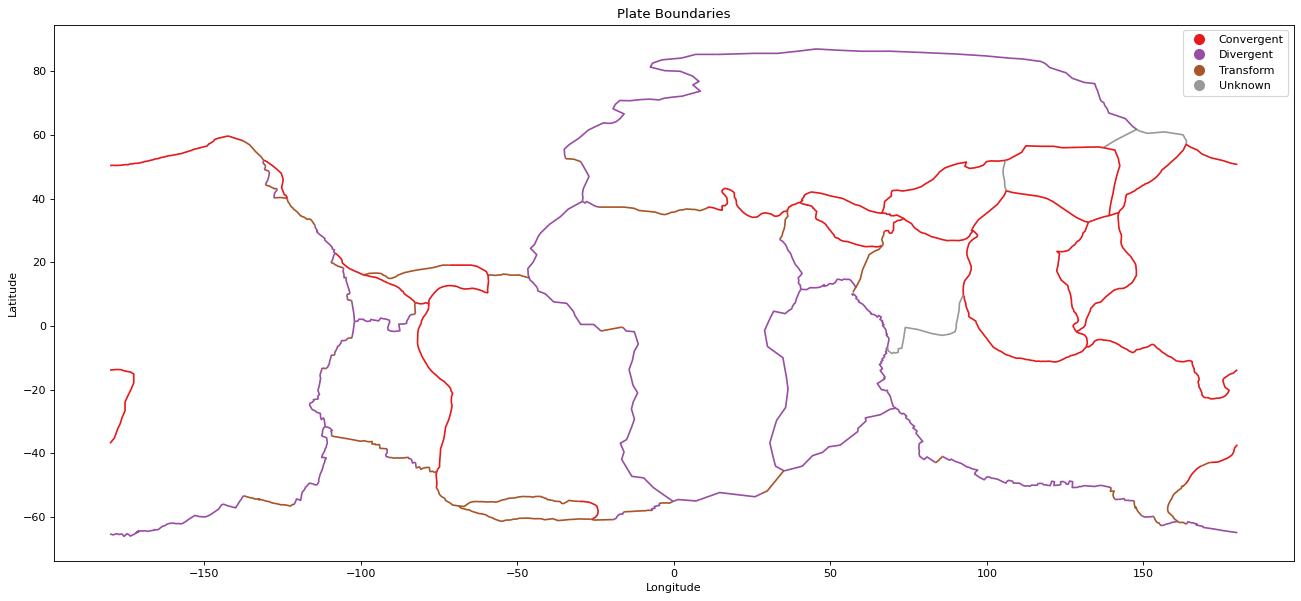

In [15]:
# Load the plate boundaries shapefile
plates_shapefile = gpd.read_file('data/plates/TectonicPlateBoundaries.shp')

# Plot the plate boundaries with color coding by unique boundaries
fig, ax = plt.subplots(figsize=(20, 20), dpi=80)  # Increase the figure size and adjust DPI
plates_shapefile.plot(column='Boundary_T', legend=True, cmap='Set1', ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Plate Boundaries')
plt.savefig('large_figure.png', bbox_inches='tight', dpi=300)  # Save to file with adjusted DPI
plt.show()


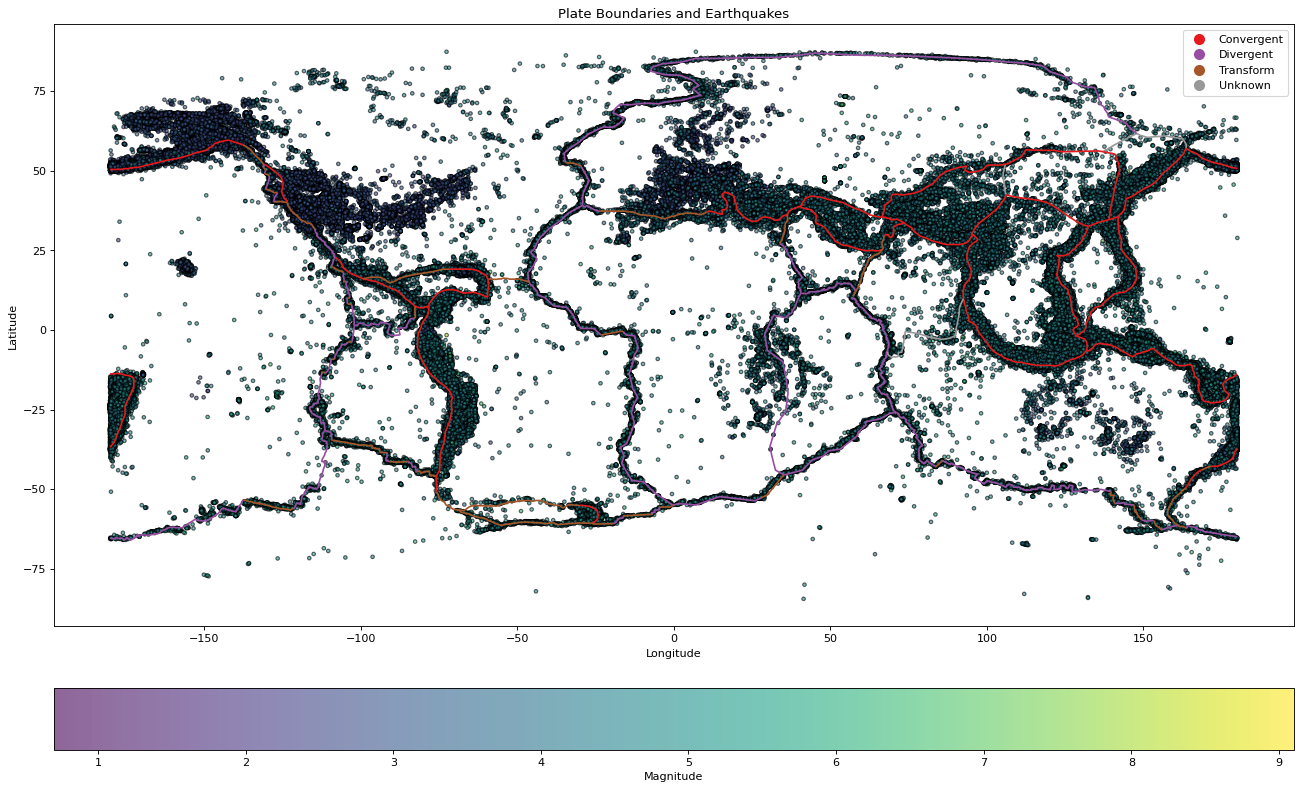

In [16]:
# Plot the plate boundaries with color coding by unique boundaries
fig, ax = plt.subplots(figsize=(20, 20), dpi=80)  # Increase the figure size and adjust DPI
plates_shapefile.plot(column='Boundary_T', legend=True, cmap='Set1', ax=ax)

# Plot the earthquakes
sc = ax.scatter(quakes['longitude'], quakes['latitude'], c=quakes['mag'], cmap='viridis', alpha=0.6, edgecolor='k', s=10)

# Add horizontal color bar
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Magnitude')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Plate Boundaries and Earthquakes')
plt.savefig('earthquakes_on_plate_boundaries.png', bbox_inches='tight', dpi=300)  # Save to file with adjusted DPI
plt.show()


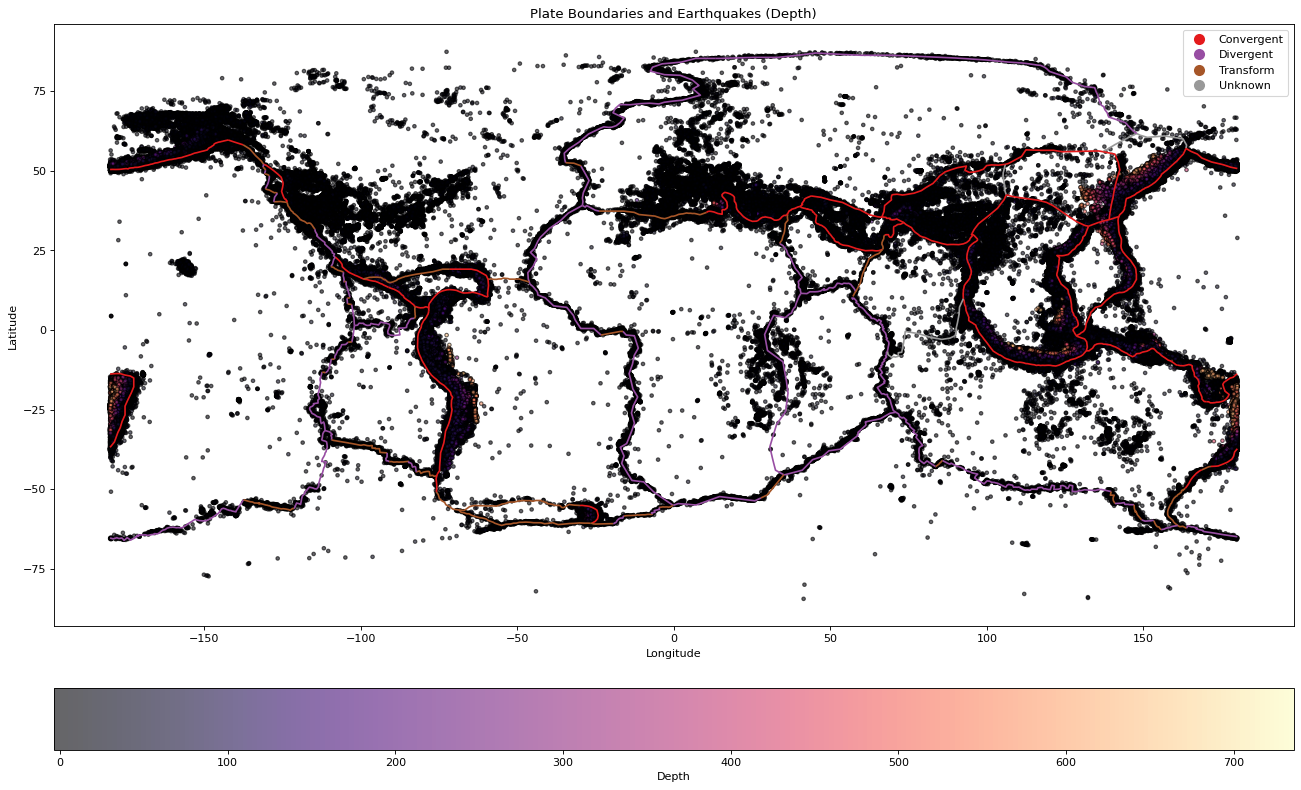

In [43]:
# Plot the plate boundaries with color coding by unique boundaries
fig, ax = plt.subplots(figsize=(20, 20), dpi=80)  # Increase the figure size and adjust DPI
plates_shapefile.plot(column='Boundary_T', legend=True, cmap='Set1', ax=ax)

# Plot the earthquakes with depth as the color
sc = ax.scatter(quakes['longitude'], quakes['latitude'], c=quakes['depth'], cmap='magma', alpha=0.6, edgecolor='k', s=10)

# Add horizontal color bar
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Depth')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Plate Boundaries and Earthquakes (Depth)')
plt.savefig('earthquakes_on_plate_boundaries_depth.png', bbox_inches='tight', dpi=300)  # Save to file with adjusted DPI
plt.show()


Most, but not all earthquakes appear to be adjacent to plate boundaries.

To my eyes it seems that the distance away from the plate boundaries is dependent upon the type of plate boundary.  I wonder if this is only with distance, or is it also with depth.  Which is kind of the same thing.  Also, the distribution of earthquakes is lopsided around the convergent boundaries.  The deeper earthquakes also appear to be further away from the convergent boundaries.  This pattern is especially clear in SE Asia and S America.  This warrants further investigation.

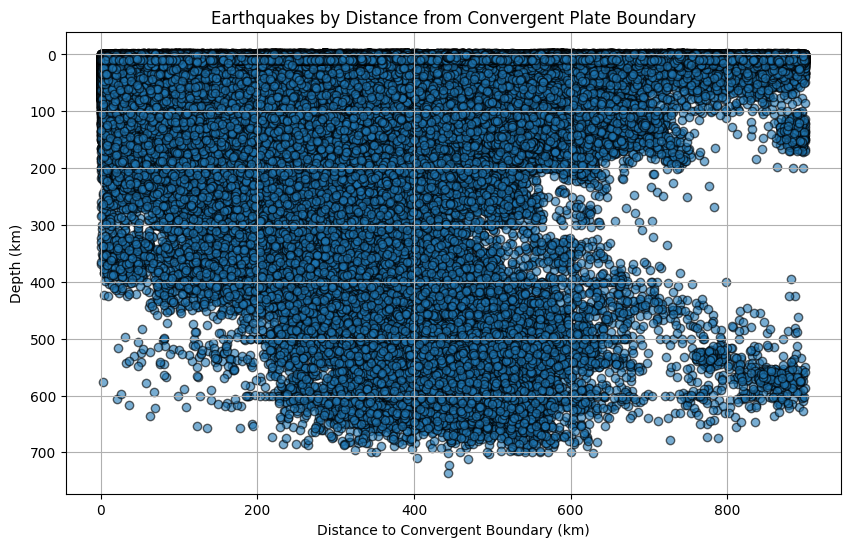

In [32]:
# Filter convergent boundaries
convergent_boundaries = plates_shapefile[plates_shapefile['Boundary_T'] == 'Convergent']

# Function to calculate the distance from a point to the nearest convergent boundary
def calculate_distance_to_convergent_boundary(point, boundaries):
    # Use shapely.ops.unary_union to combine geometries
    if not boundaries.empty:
        combined_boundaries = ops.unary_union(boundaries['geometry'].tolist())
        nearest_geom = nearest_points(point, combined_boundaries)[1]
        return point.distance(nearest_geom)
    else:
        return float('inf')

# Calculate distances for each earthquake
quakes['distance_to_convergent'] = quakes['geometry'].apply(calculate_distance_to_convergent_boundary, boundaries=convergent_boundaries)

# Convert distance to kilometers (assuming the coordinates are in degrees, we use approximate conversion)
quakes['distance_to_convergent_km'] = quakes['distance_to_convergent'] * 111  # 1 degree ~ 111 km

# Filter earthquakes within 500 km from a convergent boundary
quakes_within_500km = quakes[quakes['distance_to_convergent_km'] <= 900]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(quakes_within_500km['distance_to_convergent_km'], quakes_within_500km['depth'], alpha=0.6, edgecolor='k')
plt.xlabel('Distance to Convergent Boundary (km)')
plt.ylabel('Depth (km)')
plt.title('Earthquakes by Distance from Convergent Plate Boundary')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

This is interesting; however, a closer look at the convergent boundaries shows some differences between them.  I am going to limit the earthquakes to just those near the south american convergent boundary.  I drew a quick shape file to accomplish this.

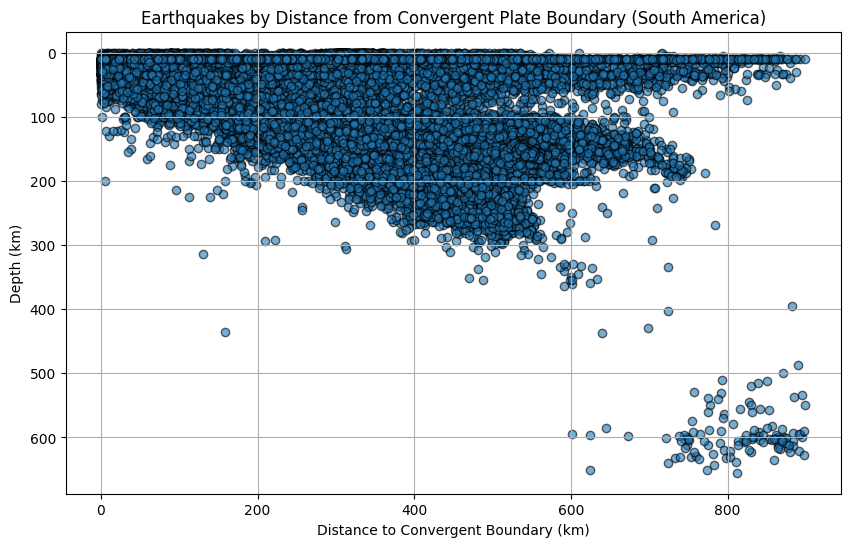

In [ ]:
# Load the South America shapefile
s_america = gpd.read_file('data/sam/s_america.shp')

# Ensure the coordinate reference systems match
quakes = quakes.set_crs(s_america.crs, allow_override=True)

# Perform spatial join to filter earthquakes within the South America polygon
quakes_in_s_america = gpd.sjoin(quakes, s_america, predicate='within')

# Filter convergent boundaries
convergent_boundaries = plates_shapefile[plates_shapefile['Boundary_T'] == 'Convergent']

# Function to calculate the distance from a point to the nearest convergent boundary
def calculate_distance_to_convergent_boundary(point, boundaries):
    # Use shapely.ops.unary_union to combine geometries
    if not boundaries.empty:
        combined_boundaries = ops.unary_union(boundaries['geometry'].tolist())
        nearest_geom = nearest_points(point, combined_boundaries)[1]
        return point.distance(nearest_geom)
    else:
        return float('inf')

# Calculate distances for each earthquake
quakes_in_s_america['distance_to_convergent'] = quakes_in_s_america['geometry'].apply(calculate_distance_to_convergent_boundary, boundaries=convergent_boundaries)

# Convert distance to kilometers (assuming the coordinates are in degrees, we use approximate conversion)
quakes_in_s_america['distance_to_convergent_km'] = quakes_in_s_america['distance_to_convergent'] * 111  # 1 degree ~ 111 km

# Filter earthquakes within 500 km from a convergent boundary
quakes_within_500km_s_america = quakes_in_s_america[quakes_in_s_america['distance_to_convergent_km'] <= 900]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(quakes_within_500km_s_america['distance_to_convergent_km'], quakes_within_500km_s_america['depth'], alpha=0.6, edgecolor='k')
plt.xlabel('Distance to Convergent Boundary (km)')
plt.ylabel('Depth (km)')
plt.title('Earthquakes by Distance from Convergent Plate Boundary (South America)')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

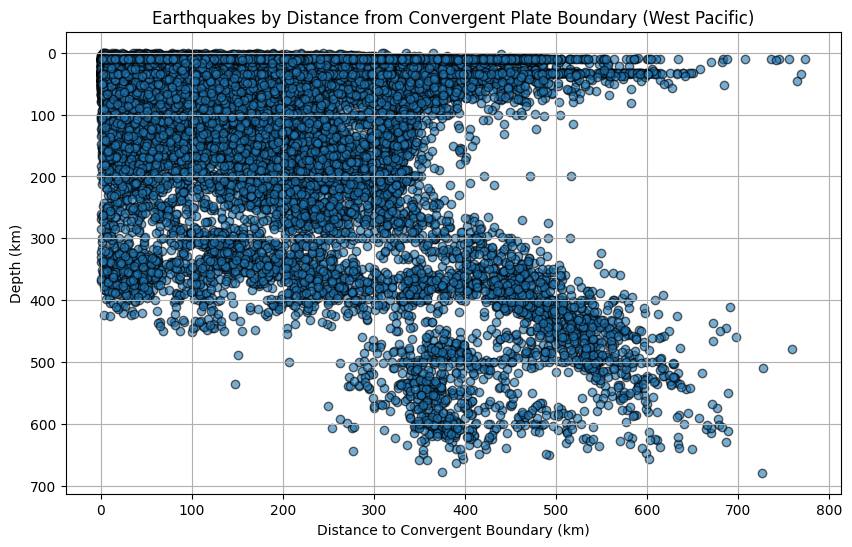

In [33]:
# Load the West Pacific shapefile
w_pac = gpd.read_file('data/wpac/w_pac.shp')

# Ensure the coordinate reference systems match
quakes = quakes.set_crs(w_pac.crs, allow_override=True)

# Perform spatial join to filter earthquakes within the West Pacific polygon
quakes_in_w_pac = gpd.sjoin(quakes, w_pac, predicate='within')

# Filter convergent boundaries
convergent_boundaries = plates_shapefile[plates_shapefile['Boundary_T'] == 'Convergent']

# Function to calculate the distance from a point to the nearest convergent boundary
def calculate_distance_to_convergent_boundary(point, boundaries):
    # Use shapely.ops.unary_union to combine geometries
    if not boundaries.empty:
        combined_boundaries = ops.unary_union(boundaries['geometry'].tolist())
        nearest_geom = nearest_points(point, combined_boundaries)[1]
        return point.distance(nearest_geom)
    else:
        return float('inf')

# Calculate distances for each earthquake
quakes_in_w_pac['distance_to_convergent'] = quakes_in_w_pac['geometry'].apply(calculate_distance_to_convergent_boundary, boundaries=convergent_boundaries)

# Convert distance to kilometers (assuming the coordinates are in degrees, we use approximate conversion)
quakes_in_w_pac['distance_to_convergent_km'] = quakes_in_w_pac['distance_to_convergent'] * 111  # 1 degree ~ 111 km

# Filter earthquakes within 500 km from a convergent boundary
quakes_within_500km_w_pac = quakes_in_w_pac[quakes_in_w_pac['distance_to_convergent_km'] <= 900]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(quakes_within_500km_w_pac['distance_to_convergent_km'], quakes_within_500km_w_pac['depth'], alpha=0.6, edgecolor='k')
plt.xlabel('Distance to Convergent Boundary (km)')
plt.ylabel('Depth (km)')
plt.title('Earthquakes by Distance from Convergent Plate Boundary (West Pacific)')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

From both of these locations, it is apparent that the depth does indeed increase away from the convergent boundaries.  For the sake of completeness, we will also look at transform and divergent boundaries.  I will limit the earthquakes to just those near the transform boundary in California.  I will also limit the earthquakes to just those near the divergent boundary in Iceland.

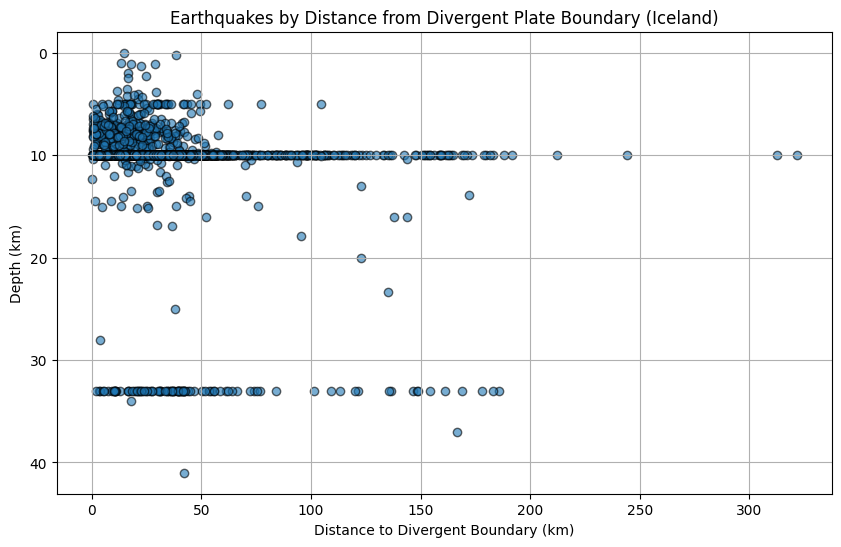

In [34]:
# Load the Iceland shapefile
iceland = gpd.read_file('data/ice/iceland.shp')

# Ensure the coordinate reference systems match
quakes = quakes.set_crs(iceland.crs, allow_override=True)

# Perform spatial join to filter earthquakes within the Iceland polygon
quakes_in_iceland = gpd.sjoin(quakes, iceland, predicate='within')

# Filter divergent boundaries
divergent_boundaries = plates_shapefile[plates_shapefile['Boundary_T'] == 'Divergent']

# Function to calculate the distance from a point to the nearest divergent boundary
def calculate_distance_to_divergent_boundary(point, boundaries):
    # Use shapely.ops.unary_union to combine geometries
    if not boundaries.empty:
        combined_boundaries = ops.unary_union(boundaries['geometry'].tolist())
        nearest_geom = nearest_points(point, combined_boundaries)[1]
        return point.distance(nearest_geom)
    else:
        return float('inf')

# Calculate distances for each earthquake
quakes_in_iceland['distance_to_divergent'] = quakes_in_iceland['geometry'].apply(calculate_distance_to_divergent_boundary, boundaries=divergent_boundaries)

# Convert distance to kilometers (assuming the coordinates are in degrees, we use approximate conversion)
quakes_in_iceland['distance_to_divergent_km'] = quakes_in_iceland['distance_to_divergent'] * 111  # 1 degree ~ 111 km

# Filter earthquakes within 500 km from a divergent boundary
quakes_within_500km_iceland = quakes_in_iceland[quakes_in_iceland['distance_to_divergent_km'] <= 500]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(quakes_within_500km_iceland['distance_to_divergent_km'], quakes_within_500km_iceland['depth'], alpha=0.6, edgecolor='k')
plt.xlabel('Distance to Divergent Boundary (km)')
plt.ylabel('Depth (km)')
plt.title('Earthquakes by Distance from Divergent Plate Boundary (Iceland)')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

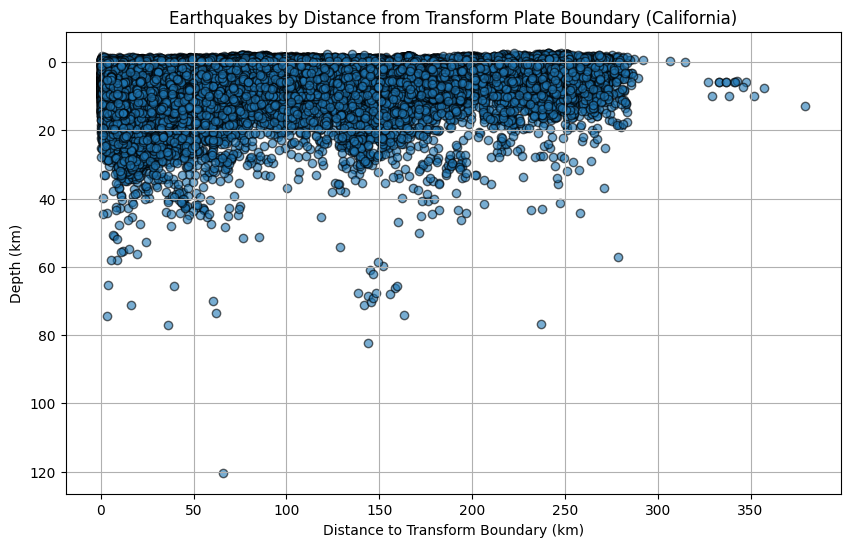

In [35]:
# Load the California shapefile
california = gpd.read_file('data/cali/cali.shp')

# Ensure the coordinate reference systems match
quakes = quakes.set_crs(california.crs, allow_override=True)

# Perform spatial join to filter earthquakes within the California polygon
quakes_in_california = gpd.sjoin(quakes, california, predicate='within')

# Filter transform boundaries
transform_boundaries = plates_shapefile[plates_shapefile['Boundary_T'] == 'Transform']

# Function to calculate the distance from a point to the nearest transform boundary
def calculate_distance_to_transform_boundary(point, boundaries):
    # Use shapely.ops.unary_union to combine geometries
    if not boundaries.empty:
        combined_boundaries = ops.unary_union(boundaries['geometry'].tolist())
        nearest_geom = nearest_points(point, combined_boundaries)[1]
        return point.distance(nearest_geom)
    else:
        return float('inf')

# Calculate distances for each earthquake
quakes_in_california['distance_to_transform'] = quakes_in_california['geometry'].apply(calculate_distance_to_transform_boundary, boundaries=transform_boundaries)

# Convert distance to kilometers (assuming the coordinates are in degrees, we use approximate conversion)
quakes_in_california['distance_to_transform_km'] = quakes_in_california['distance_to_transform'] * 111  # 1 degree ~ 111 km

# Filter earthquakes within 500 km from a transform boundary
quakes_within_500km_california = quakes_in_california[quakes_in_california['distance_to_transform_km'] <= 500]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(quakes_within_500km_california['distance_to_transform_km'], quakes_within_500km_california['depth'], alpha=0.6, edgecolor='k')
plt.xlabel('Distance to Transform Boundary (km)')
plt.ylabel('Depth (km)')
plt.title('Earthquakes by Distance from Transform Plate Boundary (California)')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

Well it looks like there is a marked difference between the depth of earthquakes and the type of plate boundaries.